In [6]:
import numpy as np 
import matplotlib.pyplot as plt
import h5py

(20, 2, 40, 8, 40)
232.73723397347035
3200
0.42615460322290716


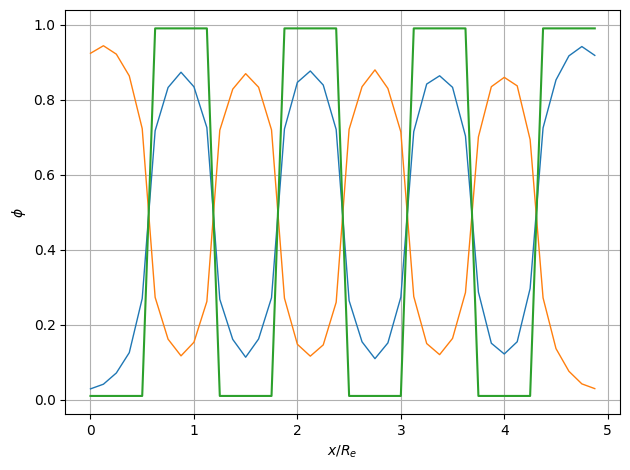

In [7]:
Nbars=[100]
dphi="dphi0.49"
offset=1 #to account for area51

plt.figure(dpi=100)
plt.grid()
y=0
for Nbar in Nbars:
    with h5py.File(f'{dphi}/Nbar{Nbar}/coord.h5', 'r') as f:
        ##number of beads per polymer
        N=int(f['parameter/reference_Nbeads'][()]) 
        #kappa
        kappa=30/N
        ##number of polymers
        n_polym=int(f['parameter/n_polymers'][()]) 
        n_poly_type=int(f['parameter/n_poly_type'][()]) 
        n_types=int(f['parameter/n_types'][()]) 
        ##box dimensions 
        lxyz=np.array(f['parameter/lxyz'])
        ##box discretization
        nxyz=np.array(f['parameter/nxyz'])
        #discretization
        dxyz=lxyz/nxyz
        #adjust lengths and discretizations
        lxyz=lxyz-2*offset*dxyz
        nxyz=nxyz-2*offset
        #umbrella field
        umb_field=np.array(f["umbrella_field"])
        #area51
        area51=np.array(f["area51"])
    with h5py.File(f'{dphi}/Nbar{Nbar}/coord_ana.h5', 'r') as f:
        #only load every other frame, the others are not optimized
        phi=np.array(f['density_field'])[1::2]
    #cell volume
    V_cell=np.prod(dxyz)
    #number of accessible cells 
    n_cells=int(len(area51[area51==0]))
    #field scaling type
    scale=n_cells/(N*n_polym)
    #reshape density and umbrella field
    phi=phi*scale
    phi=phi[:,:,area51==0].reshape(phi.shape[0],phi.shape[1],nxyz[0],nxyz[1],nxyz[2])
    umb_field=umb_field[umb_field>-1].reshape(2,nxyz[0],nxyz[2])
    #get composition
    phi_tot=np.sum(phi,axis=1)
    phi_tot[phi_tot==0]=1
    composition=phi
    for i in range(2):
        composition[:,i]=composition[:,i]/phi_tot
    print(composition.shape)
    #get phi at y value where umbrella field is defined
    phi_mean=phi[:,:,y,:].mean(axis=2)
    phi_tot=np.sum(phi_mean,axis=0)
    phi_tot[phi_tot==0]=1
    phi_mean[0]=phi_mean[0]/phi_tot
    phi_mean[1]=phi_mean[1]/phi_tot
    


    #volume
    V=V_cell*n_cells
    #average bead density
    rho0=N*Nbar
    #beads per cell
    rhoc=rho0*V_cell 
    #natural density fluctuations
    var_phi=1/(rho0*kappa*V_cell) 
    l_plot=np.arange(0,lxyz[0],dxyz[0])
    plt.xlabel("$x/R_e$")
    plt.ylabel("$\phi$")
    plt.plot(l_plot,composition.mean(axis=(0,4))[0,:,0],lw=1)
    plt.plot(l_plot,composition.mean(axis=(0,4))[1,:,0],lw=1)
    #plt.imshow(composition.mean(axis=(0))[0,:,0])
    #plt.imshow(umb_field[0])

    plt.plot(l_plot,umb_field[0,:,0])
    L=0.0
    for x in range(nxyz[0]):
        for z in range(nxyz[2]):
            for j in range(2):
                L+=(composition[0,j,x,0,z]-umb_field[j,x,z])**2
    print(L)
    L=L/len(umb_field.flatten())
    print(len(umb_field.flatten()))
    print(L/var_phi)

plt.tight_layout()
plt.savefig(f"amplitude_sa_{dphi}_Nbar{Nbar}.pdf")
